In [1]:
import pandas as pd
import numpy as np
import itertools

In [2]:
data = pd.read_csv('data/2010.csv')

/Users/adamlevin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
uCRHtps = list(itertools.product(pd.unique(data['Course_#']),pd.unique(data.Round),pd.unique(data.Hole)))

In [4]:
data.columns

Index([u'Year', u'Tourn.#', u'Player_#', u'Course_#',
       u'Permanent_Tournament_#', u'Player_First_Name', u'Player_Last_Name',
       u'Round', u'Tournament_Name', u'Course_Name', u'Hole', u'Hole_Score',
       u'Par_Value', u'Yardage', u'Shot', u'Shot_Type(S/P/D)', u'#_of_Strokes',
       u'From_Location(Scorer)', u'From_Location(Enhanced)',
       u'To_Location(Laser)', u'To_Location(Enhanced)', u'Distance',
       u'Distance_to_Pin', u'Around_the_Green_Flag', u'1st_Putt_Flag',
       u'Distance_to_Hole_after_the_Shot', u'Time', u'Elevation',
       u'Shots_taken_after', u'Went_to_X', u'Went_to_Y', u'Went_to_Z',
       u'Started_at_X', u'Started_at_Y', u'Started_at_Z'],
      dtype='object')

In [48]:
i = uCRHtps[0]
subset  = data[(data['Course_#']==i[0]) & (data.Round==i[1]) & (data.Hole==i[2]) & (data.Shot!=1)]
subset2 = data[(data['Course_#']==i[0]) & (data.Round==i[1]) & (data.Hole==i[2]) & (data.Shots_taken_after==0)]

In [49]:
scores = []
for p in pd.unique(subset['Player_#']):
    scores.append(subset[subset['Player_#']==p].iloc[0].Hole_Score)
ave_score = pd.Series(scores).mean()

In [50]:
x_h = subset2.iloc[0]['Went_to_X']
y_h = subset2.iloc[0]['Went_to_Y']

In [51]:
subset.insert(len(subset.columns),'Shots_taken_from_location',subset.Shots_taken_after + 1)
subset = subset[['Shots_taken_from_location','Started_at_X','Started_at_Y','Hole_Score','Player_#']]
subset.loc[:,'Started_at_X'] = subset.Started_at_X.values - x_h
subset.loc[:,'Started_at_Y'] = subset.Started_at_Y.values - y_h

In [52]:
subset.insert(len(subset.columns),'Distance_from_pin',(subset.Started_at_X.values**2+subset.Started_at_Y.values**2)**.5)

In [53]:
import statsmodels.api as sm

In [66]:
subset = subset.sort_values('Distance_from_pin')
x = subset.Distance_from_pin.values
y = subset.Shots_taken_from_location.values

In [68]:
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     499.0
Date:                Wed, 15 Jun 2016   Prob (F-statistic):           1.54e-65
Time:                        21:59:23   Log-Likelihood:                -632.10
No. Observations:                 298   AIC:                             1266.
Df Residuals:                     297   BIC:                             1270.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0056      0.000     22.338      0.0

In [69]:
subset.insert(len(subset.columns),'Residuals',subset.Shots_taken_from_location.values-subset.Distance_from_pin.values*.0056)

In [74]:
subset.Started_at_Y.values

array([ -9.15910800e-02,  -3.55910800e-02,   3.62408920e-01,
        -1.52591080e-01,  -5.31591080e-01,  -1.08591080e-01,
        -3.86591080e-01,  -2.87591080e-01,   4.90408920e-01,
        -6.57591080e-01,  -8.78591080e-01,   1.00040892e+00,
        -1.15059108e+00,  -1.21759108e+00,  -4.02591080e-01,
         6.92408920e-01,   1.28640892e+00,  -6.71591080e-01,
        -1.24959108e+00,  -1.36659108e+00,   8.23408920e-01,
        -4.01591080e-01,  -1.12459108e+00,  -7.85591080e-01,
        -2.33591080e-01,   1.57140892e+00,  -1.32759108e+00,
         3.74089200e-02,   5.79408920e-01,   2.10408920e-01,
         1.74840892e+00,  -3.89591080e-01,  -1.95159108e+00,
         7.99408920e-01,  -2.29659108e+00,  -2.35859108e+00,
        -1.38459108e+00,   1.40040892e+00,  -1.94559108e+00,
        -1.26559108e+00,  -2.72759108e+00,  -1.91959108e+00,
        -2.74259108e+00,   9.72408920e-01,  -1.10659108e+00,
        -2.13059108e+00,  -2.65259108e+00,   9.33408920e-01,
         2.41540892e+00,

In [9]:
subset.insert(len(subset.columns),'Angle',np.arctan2(subset.Started_at_Y.values,subset.Started_at_X.values))

In [10]:
subset = subset.sort_values('Angle')

In [11]:
import math

In [14]:
subset.loc[:,'Angle'] = np.array((subset.Angle[subset.Angle<0].values + 2*math.pi).tolist() + subset.Angle[subset.Angle>0].values.tolist())

In [15]:
subset = subset.sort_values('Angle')

In [16]:
from operator import mul    # or mul=lambda x,y:x*y
from fractions import Fraction

def nCk(n,k): 
    return int( reduce(mul, (Fraction(n-i, i+1) for i in range(k)), 1) )

In [18]:
def Bezier(df,t):
    x = 0
    y = 0
    z = 0
    n = len(df) - 1
    for i in range(n+1):
        x += nCk(n,i) * (1-t)**(n-i) * t**(i) * df.Started_at_X.values[i]
        y += nCk(n,i) * (1-t)**(n-i) * t**(i) * df.Started_at_Y.values[i]
        z += nCk(n,i) * (1-t)**(n-i) * t**(i) * df.Shots_taken_from_location[i]
    return (x,y,z)

In [19]:
subset = pd.DataFrame({column:0 for column in subset.columns.tolist()},index=[0]).append(subset,ignore_index=True)

In [21]:
subset.loc[0,'Shots_taken_from_location'] = 1

In [23]:
x,y,z = [],[],[]
for t in range(100+1):
    a = Bezier(subset,float(t)/100)
    x.append(a[0])
    y.append(a[1])
    z.append(a[2])

In [24]:
import matplotlib as m
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [33]:
subset.Shots_taken_from_location.values

array([1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,
       1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2,
       1, 1, 1, 1, 1, 3, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 3,
       1, 3, 3, 3])

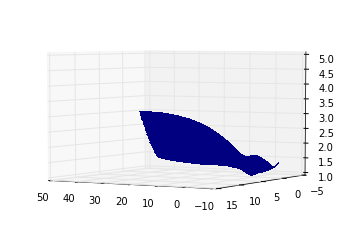

In [28]:
from scipy.interpolate import griddata
xyz = {'x': np.array(x), 'y': np.array(y), 'z': np.array(z)}
# put the data into a pandas DataFrame (this is what my data looks like)
df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 

# re-create the 2D-arrays
x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
x2, y2 = np.meshgrid(x1, y1)
z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='cubic')

Gx, Gy = np.gradient(z2) # gradients with respect to x and y
G = (Gx**2+Gy**2)**.5  # gradient magnitude
N = G/G.max()

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x2, y2, z2,rstride=1, cstride=1,facecolors=cm.jet(N),linewidth=0, antialiased=False, shade=False)

ax.view_init(elev=4, azim=120)
ax.set_zlim3d(1,5)
# ax.set_xlim3d(-20,20)
# ax.set_ylim3d(-20,20)

plt.show()